<a href="https://colab.research.google.com/github/heesukjang/W207_AppliedML_Fall2022/blob/main/11_18_wRasika_KerasTuner_plots_Final_HyperparamTuning_ImageAug_CM_CR_ROCcurve_IDC_Prediction_heesuk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## FALL 2022<br>
W207 Applied Machine Learning<br>
Heesuk Jang
 

**XGBoost:** an optimized version of Gradient Boosting / much more evolved version of Random Forest in terms of speed and accuracy

#Predicting IDC with Breast Histopathology Images using CNN



In [1]:
import pandas as pd
import numpy as np
import os
import re
import random
import joblib
import glob
import itertools

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.patches as patches

from sklearn.utils import shuffle
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy import stats
from collections import Counter
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *                            # confusion_matrix, log_loss, accuracy_score
from sklearn.model_selection import *                    # train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing
from sklearn.preprocessing import *  
# from sklearn.ensemble import *
from sklearn.svm import *
from sklearn.linear_model import *                       # LinearRegression
from sklearn.discriminant_analysis import *
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.plotting import plot_decision_regions

import tensorflow as tf
from tensorflow import keras
from keras import metrics
from tensorflow.keras import initializers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import RandomFlip, RandomZoom, RandomRotation, Conv2D, MaxPooling2D, AveragePooling2D, Input, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD, Adadelta, Adagrad, RMSprop
from keras.layers import ReLU, LeakyReLU
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import ReLU, LeakyReLU

from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve

tf.get_logger().setLevel('INFO')

import cv2 as cv
import skimage.io as io

import warnings
warnings.filterwarnings('ignore')

# Required to read the data from Kaggle
from google.colab import drive
# drive.mount('/content/gdrive')
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle"

from google.colab import drive
drive.mount('/content/gdrive')

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Install Optuna and Version Check

In [2]:
# !pip install --quiet optuna
# import optuna
# optuna.__version__

In [3]:
!pip install -q -U keras-tuner
import keras_tuner as kt

# !pip install xgboost
import xgboost as xgb

## Enabling and testing the GPU

In [4]:
# import tensorflow as tf
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

## Enabling and testing the TPU

## Observe TensorFlow speedup on GPU relative to CPU

In [5]:
# !unzip gdrive/MyDrive/Kaggle/CNN_IDC/Dataset.zip

#replace these paths with the paths of your 
val_image_directory = '/content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset/Validate'
train_image_directory = '/content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset/Train'
test_image_directory = '/content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset/Test'
directory_path = '/content/gdrive/MyDrive/Kaggle/CNN_IDC'

In [6]:
def get_paths(directory):
  all_path = []
  idc_image_path = []
  idc_image_label = []

  for dir, subdir, files in os.walk(directory):
    path = dir + "/"
    all_path.append(path)

  for i in range(len(all_path)):
    for file in os.listdir(all_path[i]):
      test = file
      path = all_path[i] + test
      if path.lower().endswith('.png'):
        idc_image_path.append(path)

  for i in range(len(idc_image_path)):
    split_test = idc_image_path[i]
    split_path = split_test.split("/")
    directory_name = split_path[7]
    idc_image_label.append('class_' + split_path[8])
  return idc_image_path, idc_image_label, directory_name

In [7]:
train_paths, train_labels, train_dir = get_paths(train_image_directory)
val_paths, val_labels, val_dir = get_paths(val_image_directory)
test_paths, test_labels, test_dir = get_paths(test_image_directory)

In [8]:
print(train_labels[:5])
print(train_labels[-5:])

print(len(train_paths), len(train_labels))
print(len(test_paths), len(test_labels))
print(len(val_paths), len(val_labels))

['class_0', 'class_0', 'class_0', 'class_0', 'class_0']
['class_1', 'class_1', 'class_1', 'class_1', 'class_1']
800 800
200 200
200 200


In [9]:
print(train_paths[:2])
print(train_labels[:10])
print(train_dir)

['/content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset/Train/0/12880_idx5_x451_y701_class0.png', '/content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset/Train/0/9345_idx5_x2001_y2001_class0.png']
['class_0', 'class_0', 'class_0', 'class_0', 'class_0', 'class_0', 'class_0', 'class_0', 'class_0', 'class_0']
Train


In [10]:
def create_dataframes(idc_image_path, idc_image_label, directory_name):
  same_name = directory_name.lower() + '_'
  #creating the dataframes that we will be passing to our generators
  idc_data_cleaned = {'path': idc_image_path,
            'label': idc_image_label}
  idc_df = pd.DataFrame(idc_data_cleaned)
  idc_df['label_int'] = idc_df['label'].str.split("_", expand=True)[1]    # Added a new column 'label_int'
  df = idc_df.sample(frac = 1)
  print(df)
  csv_path = directory_path
  csv_file = df.to_csv(csv_path + '/' + same_name + 'idc_dataframe.csv')
  csv_file_path = csv_path + '/' + same_name + 'idc_dataframe.csv'
  return csv_file_path

In [11]:
train_dataframe = create_dataframes(train_paths, train_labels, train_dir)
print('type(train_dataframe): ',type(train_dataframe))
train_dataframe

                                                  path    label label_int
116  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0         0
260  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0         0
569  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1         1
78   /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0         0
736  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1         1
..                                                 ...      ...       ...
294  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0         0
579  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1         1
451  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1         1
543  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1         1
73   /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0         0

[800 rows x 3 columns]
type(train_dataframe):  <class 'str'>


'/content/gdrive/MyDrive/Kaggle/CNN_IDC/train_idc_dataframe.csv'

In [12]:
train_dataframe = create_dataframes(train_paths, train_labels, train_dir)
train_generator = pd.read_csv(train_dataframe)

test_dataframe = create_dataframes(test_paths, test_labels, test_dir)
test_generator = pd.read_csv(test_dataframe)

val_dataframe = create_dataframes(val_paths, val_labels, val_dir)
val_generator = pd.read_csv(val_dataframe)

                                                  path    label label_int
774  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1         1
152  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0         0
354  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0         0
91   /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0         0
199  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0         0
..                                                 ...      ...       ...
124  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0         0
315  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0         0
22   /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0         0
482  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1         1
784  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1         1

[800 rows x 3 columns]
                                                  path    label label_int
190  /content/

In [13]:
from tqdm import tqdm # import tqdm

# Apply gray scale to all images, flatten and store array / shape in new columns
def get_img_arrays(df,):
    # read each image array from corresponding path as grayscale and flatten the image array
    df['img_array'] = df.progress_apply(lambda x : io.imread(x['path'],as_gray=True).flatten(),axis=1) # make sure to specify axis = 1
    # get the shape of each image array and store it in the dataframe
    df['array_shape'] = df.progress_apply(lambda x : x['img_array'].shape[0],axis=1) # make sure to specify axis = 1
    return df


In [14]:
from tqdm import tqdm # import tqdm
tqdm.pandas() # initialize tqdm for pandas

# # tqdm is a library that enables you to visualize the progress of a for loop by displaying a configurable progress bar

train_generator = get_img_arrays(df = train_generator)
val_generator = get_img_arrays(df = val_generator)
test_generator = get_img_arrays(df = test_generator)

100%|██████████| 200/200 [00:00<00:00, 40173.40it/s]


In [15]:
# print(train_generator.array_shape.value_counts())
# print(val_generator.array_shape.value_counts())
# print(test_generator.array_shape.value_counts())

In [16]:
# drop these images as they add unnecessary noise to our model
train_weird_imgs = train_generator[train_generator['array_shape'] != 2500]
val_weird_imgs = val_generator[val_generator['array_shape'] != 2500]
test_weird_imgs = test_generator[test_generator['array_shape'] != 2500]


weird_imgs = train_weird_imgs.append(val_weird_imgs)
weird_imgs = weird_imgs.append(test_weird_imgs)
weird_imgs['dataset'] = weird_imgs['path'].str.split('/', expand=True)[7]
weird_imgs.reset_index(drop=True)

train_generator.drop(train_weird_imgs.index,inplace=True)
val_generator.drop(val_weird_imgs.index,inplace=True)
test_generator.drop(test_weird_imgs.index,inplace=True)

# print(len(weird_imgs))
# print(len(train_generator))
# print(len(val_generator))
# print(len(test_generator))
# print(train_generator.columns)
# val_generator.reset_index(drop=True)

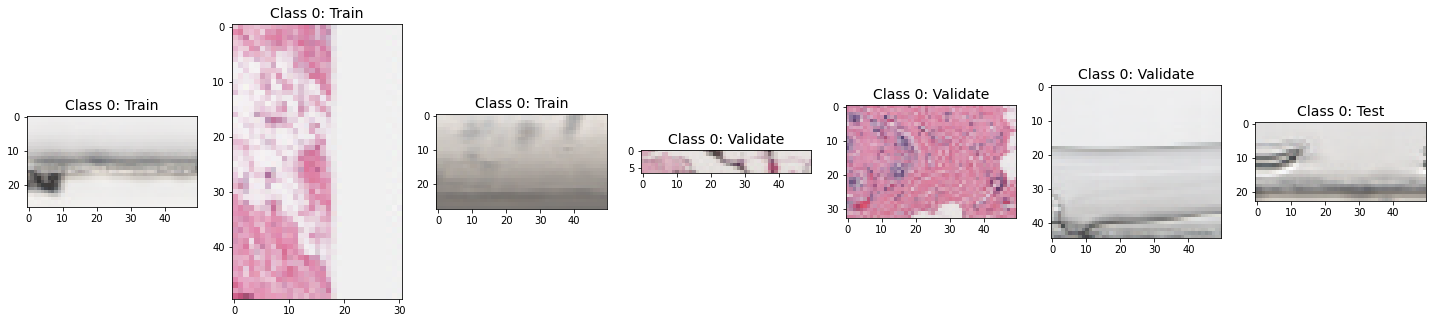

In [17]:
import cv2 as cv
import skimage.io as io

def display_images(subclass):
  fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(20,8))
  for idx, ax in enumerate(axes.flat):
    image_wo_path = os.path.basename(subclass.path[idx])
    # print(image_wo_path)
    subtitle = 'Class ' + image_wo_path.rsplit('.')[0][-1] + ': ' + subclass.dataset[idx]
    img = io.imread(subclass.path[idx])
    ax.imshow(img)
    # ax.axis('off')
    ax.set_title(subtitle, size=14)   
  fig.tight_layout() 
  plt.show() 

print()
display_images(weird_imgs.reset_index(drop=True))

# Preprocessing data using ImageDataGenerator

In [18]:
BATCH_SIZE = 32
EPOCHS = 8
IMG_SIZE = (50,50)

In [19]:
# https://faroit.com/keras-docs/0.3.3/preprocessing/image/
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

# def data_generator():

# with_aug_datagen = ImageDataGenerator(
#     # featurewise_center = True,                     # transforms the images to 0 mean
#     # featurewise_std_normalization = True,          # divide inputs by std of the dataset
#     # zca_epsilon=1e-06,
#     recale = 1./255,
#     rotation_range=30,                      # randomly rotate image by 10 degrees
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     brightness_range=[0.4, 1.5],
#     shear_range=0.2,                        # distort image along an axis mostly to create or recify the perception angles     
#     zoom_range=0.2,                         # zomming image: zoom_range > 1 => zoom out, zoom_range < 1 => zoom in                  
#     fill_mode='nearest',                    # when the image is rotated, some pixels will move outside the image and leave an empty area that needs to be filled in, 'nearest': simply replace the empty area with the nearest spectral values.
#     horizontal_flip=True,
#     vertical_flip=True)
    
# without_aug_datagen = ImageDataGenerator()
# without_aug_datagen = ImageDataGenerator(rescale = 1./255)
                                        #  featurewise_center = True, featurewise_std_normalization = True)   # False is default so need to set to True

# =================================================================
# if with_augmented_images:
# train_data_generator = with_aug_datagen.flow_from_dataframe(
#       train_generator,
#       directory = None,
#       x_col =  'path',
#       y_col =  'label',
#       weight_col=None,
#       target_size=(50,50),
#       color_mode="grayscale",
#       class_mode="categorical",
#       batch_size=32,
#       shuffle=True,
#       seed=1234
#       # validate_filenames=True
#   )
# else:

without_aug_datagen = ImageDataGenerator(rescale = 1./255)

train_data_generator = without_aug_datagen.flow_from_dataframe(
    train_generator,
    directory = '../Dataset/Train/',
    x_col =  'path',
    y_col =  'label',
    # weight_col=None,
    target_size=IMG_SIZE,
    color_mode="grayscale",
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=1234
    # validate_filenames=True
)
# print(train_data_generator.shape)

validation_data_generator = without_aug_datagen.flow_from_dataframe(
    val_generator,
    directory = '../Dataset/Validate/',
    x_col =  'path',
    y_col =  'label',
    # weight_col=None,
    # target_size=(hp_target_size, hp_target_size),
    target_size=IMG_SIZE,
    color_mode="grayscale",
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=1234
    # validate_filenames=True
)

test_data_generator = without_aug_datagen.flow_from_dataframe(
    test_generator,
    # directory = None,
    directory = '../Dataset/Test/',
    x_col =  'path',
    y_col =  'label',
    # weight_col=None,
    target_size=IMG_SIZE,
    color_mode="grayscale",
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False,              # Kesha set to shuffle=True but we don't want to shuffle our testing data around, which it does so by default
    seed=1234
    # validate_filenames=True
)
# return train_data_generator, validation_data_generator, test_data_generator

# train_data_generator, validation_data_generator, test_data_generator = data_generator(with_augmented_images=True)
# train_data_generator, validation_data_generator, test_data_generator = data_generator()

Found 797 validated image filenames belonging to 2 classes.
Found 197 validated image filenames belonging to 2 classes.
Found 199 validated image filenames belonging to 2 classes.


# Build CNN Model and Hyperparameter Tuning
- **ReduceLROnPlateau**: A scheduling technique that monitors a particular quantity and decays the learning rate when the quantity is stop improving.
- **ModelCheckpoint**: A sch
- **BatchNormalization**: A feature that we add between the layers of neural network and it continuously takes the output from the previous layer and normalizes it before sending it to the next layer thereby helping stablizing the NN

# Best Hyperparameters to Tune
- Learning Rate
- Optimizers
- Activation Functions
- Epochs
- Dropout rate
- Number of layers and units (filters)

In [20]:
# img_height = 50
# img_width = 50
# img_channel = 1
# input_shape = (img_height, img_width, img_channel)

In [21]:
# from keras.layers import ReLU, LeakyReLU
# # https://keras.io/guides/keras_tuner/getting_started/

# def build_cnn(hp): 
#   # train_data_generator, validation_data_generator, test_data_generator = data_generator(hp)

#   tf.keras.backend.clear_session()
#   tf.random.set_seed(0)

# # Define ranges of hyperparam values 
#   # hp_img_size = hp.get('hp_target_size')
#   # hp_img_size = hp.Int('img_size', 50,96,120)
#   # hp_img_size = hp.Int('img_size', 50,96)
#   hp_kernel_size = hp.Int('kernel_size', min_value=2, max_value=5, step=1)
#   hp_strides = hp.Int('strides', min_value=1, max_value=2, step=1)
#   hp_pool_size = hp.Int('pool_size', min_value=2, max_value=3, step=1)
#   hp_activation = hp.Choice('activation', values=['tanh', 'relu', 'softmax', 'sigmoid', 'leaky_relu', 'elu', 'gelu','selu','swish'], default='relu')
#   hp_optimizer = hp.Choice('optimizer', values=['adadelta', 'adagrad', 'adam', 'rmsprop', 'sgd'], default='adam')
#   hp_filters_1 = hp.Int('filters_1', min_value=8, max_value=64, step=8)
#   hp_filters_2 = hp.Int('filters_2', min_value=8, max_value=128, step=16)
#   hp_filters_3 = hp.Int('filters_3', min_value=32, max_value=128, step=16)
#   hp_dense = hp.Int('dense_units', min_value=32, max_value=512, step=34)
#   hp_learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default=1e-2)
#   hp_dropout_1 = hp.Float('dropout_rate_1', min_value=0.1, max_value=0.5, default=0.1, step=0.1)
#   hp_dropout_2 = hp.Float('dropout_rate_2', min_value=0.3, max_value=0.5, default=0.25, step=0.1)
#   hp_dropout_3 = hp.Float('dropout_rate_3', min_value=0.3, max_value=0.5, default=0.35, step=0.1)
#   hp_reduction_type = hp.Choice('reduction_type', values=['global_avg_pooling2d', 'max_pooling2d'])

#   # Define the model
#   model = tf.keras.Sequential()
#   # print('input_shape: ', (hp_img_size, hp_img_size, 1))
#   # 1st set of neural network layers (Input layer)
#   model.add(Conv2D(filters=hp_filters_1, kernel_size=(hp_kernel_size,hp_kernel_size), padding='same', activation=hp_activation, input_shape = (50,50,1)))  
#   # model.add(Conv2D(filters=hp_filters_1, kernel_size=(hp_kernel_size,hp_kernel_size), padding='same', activation=hp_activation, input_shape = (hp_img_size, hp_img_size, 1)))  
#   if hp_reduction_type == 'global_avg_pooling2d':
#     model.add(GlobalAveragePooling2D(keepdims=True))
#   else:
#     model.add(MaxPooling2D(pool_size=(hp_pool_size,hp_pool_size), strides=(hp_strides,hp_strides)))  
#   # if hp.Boolean('dropout_1'):
#     # model.add(Dropout(hp_dropout_1))
  
#   # 2nd set of neural network layers
#   # if hp.Boolean('conv_layer_2'):  
#   model.add(Conv2D(filters=hp_filters_2, kernel_size=(hp_kernel_size,hp_kernel_size), padding='same', activation=hp_activation))
#   # if hp.Boolean('BatchNormalization_1'):
#   model.add(BatchNormalization())
#   if hp_reduction_type == 'global_avg_pooling2d':
#     model.add(GlobalAveragePooling2D(keepdims=True))
#   else:
#     model.add(MaxPooling2D(pool_size=(hp_pool_size,hp_pool_size), strides=(hp_strides,hp_strides)))  
#   # if hp.Boolean('dropout_2'):
#     # model.add(Dropout(hp_dropout_1))

#   # 3rd set of neural network layers
#   # if hp.Boolean('conv_layer_3'):  
#   model.add(Conv2D(filters=hp_filters_3, kernel_size=(hp_kernel_size,hp_kernel_size), padding='same', activation=hp_activation.lower()))
#   # if hp.Boolean('BatchNormalization_2'):
#   model.add(BatchNormalization())
#   if hp_reduction_type == 'global_avg_pooling2d':
#     model.add(GlobalAveragePooling2D(keepdims=True))
#   else:
#     model.add(MaxPooling2D(pool_size=(hp_pool_size,hp_pool_size), strides=(hp_strides, hp_strides)))  
#   # if hp.Boolean('dropout_3'):
#   # model.add(Dropout(hp_dropout_2))

#   # Flatten layer
#   model.add(Flatten())

#   # Fully connected dense layer
#   model.add(Dense(units = hp_dense, activation = hp_activation))
#   # if hp.Boolean('BatchNormalization_3'):
#   model.add(BatchNormalization())
#   if hp.Boolean('dropout_4'):
#     model.add(Dropout(hp_dropout_3))
  
#   # Output layer
#   model.add(Dense(units = 2, activation = 'softmax'))        # output layer
  
#   # Define the optimizer
#   def selected_optimizer(optimizer):
#     if optimizer.lower() == 'sgd':
#         return SGD(learning_rate=hp_learning_rate)           # SGD(learning_rate=learning_rate, momentum=0.95, decay=1, nesterov=True)
#     elif optimizer.lower() == 'adam':
#         return Adam(learning_rate=hp_learning_rate)          # Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-8, kappa=1-1e-8)
#     elif optimizer.lower() == 'adadelta':
#         return Adadelta(learning_rate=hp_learning_rate)      # Adadelta(learning_rate=learning_rate, rho=0.95, epsilon=1e-6)
#     elif optimizer.lower() == 'adagrad':
#         return Adagrad(learning_rate=hp_learning_rate)       # Adagrad(learning_rate=learning_rate, epsilon=1e-6)
#     elif optimizer.lower() == 'rmsprop':
#         return RMSprop(learning_rate=hp_learning_rate)       # RMSprop(learning_rate=learning_rate, rho=0.9, epsilon=1e-6)

#   # Compile the model
#   model.compile(loss=CategoricalCrossentropy(), 
#                 optimizer=selected_optimizer(hp_optimizer), 
#                 metrics=['accuracy'])
#   return model

In [22]:
from keras.layers import ReLU, LeakyReLU
# https://keras.io/guides/keras_tuner/getting_started/

def build_cnn(hp): 
  # train_data_generator, validation_data_generator, test_data_generator = data_generator(hp)

  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

# Define ranges of hyperparam values 
  # hp_img_size = hp.get('hp_target_size')
  # hp_img_size = hp.Int('img_size', 50,96,120)
  # hp_img_size = hp.Int('img_size', 50,96)
  hp_kernel_size = hp.Int('kernel_size', min_value=2, max_value=5, step=1)
  hp_strides = hp.Int('strides', min_value=1, max_value=2, step=1)
  hp_pool_size = hp.Int('pool_size', min_value=2, max_value=3, step=1)
  hp_activation = hp.Choice('activation', values=['relu', 'leaky_relu', 'elu', 'gelu','selu'], default='relu')
  hp_optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd'], default='adam')
  hp_filters_1 = hp.Int('filters_1', min_value=8, max_value=64, step=8)
  # hp_filters_2 = hp.Int('filters_2', min_value=8, max_value=128, step=16)
  # hp_filters_3 = hp.Int('filters_3', min_value=32, max_value=128, step=16)
  hp_dense = hp.Int('dense_units', min_value=32, max_value=256, step=34)
  hp_learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default=1e-2)
  hp_dropout = hp.Float('dropout_rate', min_value=0.1, max_value=0.6, default=0.1, step=0.1)
  # hp_dropout_2 = hp.Float('dropout_rate_2', min_value=0.3, max_value=0.5, default=0.25, step=0.1)
  # hp_dropout_3 = hp.Float('dropout_rate_3', min_value=0.3, max_value=0.5, default=0.35, step=0.1)
  hp_reduction_type = hp.Choice('reduction_type', values=['global_avg_pooling2d', 'max_pooling2d'])

  # Define the model
  model = tf.keras.Sequential()

  # Input layer
  model.add(Conv2D(hp.Int('input_units', min_value=16, max_value=64, step=16), kernel_size=(hp_kernel_size,hp_kernel_size), padding='same', activation=hp_activation, input_shape = (50,50,1)))  
  if hp_reduction_type == 'global_avg_pooling2d':
    model.add(GlobalAveragePooling2D(keepdims=True))
  else:
    model.add(MaxPooling2D(pool_size=(hp_pool_size,hp_pool_size), strides=(hp_strides,hp_strides)))  

  
  # 2nd set of neural network layers
  # if hp.Boolean('conv_layer_2'):  
  for i in range(hp.Int('n_layers', 1, 3)):
    model.add(Conv2D(hp.Int(f'conv2d_{i}_units', min_value=32, max_value=128, step=32), kernel_size=(hp_kernel_size,hp_kernel_size), padding='same', activation=hp_activation))
    if hp_reduction_type == 'global_avg_pooling2d':
      model.add(GlobalAveragePooling2D(keepdims=True))
    else:
      model.add(MaxPooling2D(pool_size=(hp_pool_size,hp_pool_size), strides=(hp_strides,hp_strides)))  
    model.add(BatchNormalization())
    if hp.Boolean('dropout'):
      model.add(Dropout(hp_dropout))

  # # 3rd set of neural network layers
  # # if hp.Boolean('conv_layer_3'):  
  # model.add(Conv2D(filters=hp_filters_3, kernel_size=(hp_kernel_size,hp_kernel_size), padding='same', activation=hp_activation.lower()))
  # # if hp.Boolean('BatchNormalization_2'):
  # model.add(BatchNormalization())
  # if hp_reduction_type == 'global_avg_pooling2d':
  #   model.add(GlobalAveragePooling2D(keepdims=True))
  # else:
  #   model.add(MaxPooling2D(pool_size=(hp_pool_size,hp_pool_size), strides=(hp_strides, hp_strides)))  
  # # if hp.Boolean('dropout_3'):
  # # model.add(Dropout(hp_dropout_2))

  # Flatten layer
  model.add(Flatten())

  # Fully connected dense layer
  model.add(Dense(units = hp_dense, activation = hp_activation))
  model.add(BatchNormalization())
  # if hp.Boolean('dropout_4'):
  model.add(Dropout(hp_dropout))
  
  # Output layer
  model.add(Dense(units = 2, activation = 'softmax'))        # output layer
  
  # Define the optimizer
  def selected_optimizer(optimizer):
    if optimizer.lower() == 'sgd':
        return SGD(learning_rate=hp_learning_rate)           # SGD(learning_rate=learning_rate, momentum=0.95, decay=1, nesterov=True)
    elif optimizer.lower() == 'adam':
        return Adam(learning_rate=hp_learning_rate)          # Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-8, kappa=1-1e-8)
    # elif optimizer.lower() == 'adadelta':
    #     return Adadelta(learning_rate=hp_learning_rate)      # Adadelta(learning_rate=learning_rate, rho=0.95, epsilon=1e-6)
    # elif optimizer.lower() == 'adagrad':
    #     return Adagrad(learning_rate=hp_learning_rate)       # Adagrad(learning_rate=learning_rate, epsilon=1e-6)
    elif optimizer.lower() == 'rmsprop':
        return RMSprop(learning_rate=hp_learning_rate)       # RMSprop(learning_rate=learning_rate, rho=0.9, epsilon=1e-6)

  # Compile the model
  model.compile(loss=CategoricalCrossentropy(), 
                optimizer=selected_optimizer(hp_optimizer), 
                metrics=['accuracy'])
  return model

Then, the **max_trials** variable represents the number of hyperparameter combinations that will be tested by the tuner, while the **execution_per_trial** variable is the number of models that should be built and fit for each trial for robustness purposes. The next section explains how to set them

https://www.sicara.fr/blog-technique/hyperparameter-tuning-keras-tuner<br>
https://www.kaggle.com/code/fchollet/keras-kerastuner-best-practices/notebook

In [23]:
from tensorflow.keras.callbacks import EarlyStopping

stop_early = EarlyStopping(monitor = 'val_accuracy', mode = 'max', patience = 3)
# stop_early = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 3)

# RandomSearch
tuner = kt.RandomSearch(
          # CNN_HyperModel(),
          build_cnn,
          objective="val_accuracy",
          max_trials=5,                     # max_trials=50 or 10,
          executions_per_trial=2,           # executions_per_trial=10,
          overwrite=True,
          directory="hj_dir",
          project_name="breast_cancer_classification")

tuner.search(train_data_generator, 
             epochs=EPOCHS, 
             callbacks=[stop_early], 
             validation_data=validation_data_generator)

INFO:tensorflow:Oracle triggered exit


Trial 5 Complete [00h 00m 32s]
val_accuracy: 0.697969526052475

Best val_accuracy So Far: 0.7309644818305969
Total elapsed time: 00h 03m 06s


In [24]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, classification_report
from sklearn import svm
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve

https://www.analyticsvidhya.com/blog/2020/08/image-augmentation-on-the-fly-using-keras-imagedatagenerator/

Epoch 1/8
25/25 [==============================] - ETA: 0s - loss: 1.5973 - accuracy: 0.6813
Epoch 1: val_accuracy improved from -inf to 0.51269, saving model to weights.hdf5
25/25 [==============================] - 6s 199ms/step - loss: 1.5973 - accuracy: 0.6813 - val_loss: 0.7415 - val_accuracy: 0.5127 - lr: 0.0056
Epoch 2/8
25/25 [==============================] - ETA: 0s - loss: 0.5650 - accuracy: 0.7528
Epoch 2: val_accuracy improved from 0.51269 to 0.72081, saving model to weights.hdf5
25/25 [==============================] - 4s 166ms/step - loss: 0.5650 - accuracy: 0.7528 - val_loss: 0.6568 - val_accuracy: 0.7208 - lr: 0.0056
Epoch 3/8
25/25 [==============================] - ETA: 0s - loss: 0.5689 - accuracy: 0.7440
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005628390237689019.

Epoch 3: val_accuracy did not improve from 0.72081
25/25 [==============================] - 2s 74ms/step - loss: 0.5689 - accuracy: 0.7440 - val_loss: 0.6299 - val_accuracy: 0.6954 - lr: 0.

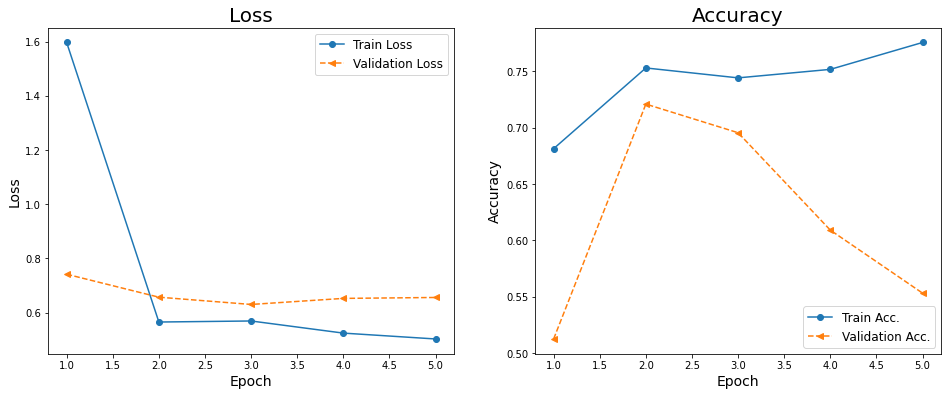

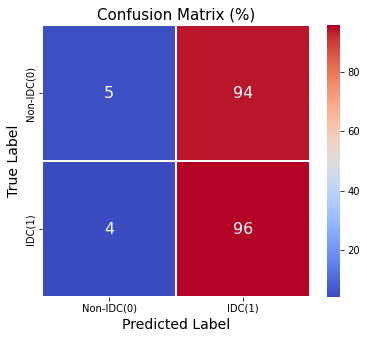

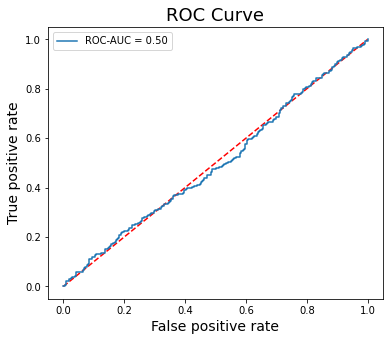

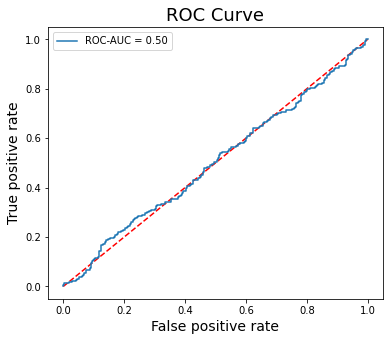

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 128)       18560     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 46, 46, 128)      0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 128)      512       
 ormalization)                                                   
                                                        

,Augmented,Test_acc,Training_acc,Val_acc,Num_params,Accuracy,Precision,Recall,F1_score,Error Rate,ROC-AUC score,Cohen Kappa,Zero-One Loss
0,NO,0.53,0.78,0.55,"54,731,944",0.51,0.5,0.96,0.66,0.49,0.5,0.01,0.49


In [25]:
# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]     # num_trials=5

best_hps = tuner.get_best_hyperparameters()[0]     # num_trials=5
model = tuner.hypermodel.build(best_hps)
# model = tuner.get_best_models()[0]
# model = build_cnn(best_hps)

# from sklearn.model_selection import cross_val_score
# from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, classification_report
# from sklearn import svm
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve

lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, min_delta=0.0001, patience=1, verbose=1)

file_path = 'weights.hdf5'    # save the weights and biases
checkpoint = ModelCheckpoint(file_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Fit with the entire dataset (both training and validation sets)

history = model.fit(train_data_generator,
                  epochs=EPOCHS,
                  shuffle=True,
                  batch_size=BATCH_SIZE,                  
                  # steps_per_epoch=train_generator.shape[0]//BATCH_SIZE, 
                  callbacks=[lr_reduce, checkpoint, stop_early],
                  validation_data = validation_data_generator)
                  # validation_steps=val_generator.shape[0]//BATCH_SIZE)
# pd.DataFrame(history.history)

# Plot loss and accuracy of best model on every epoch
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(1,2,1)
ax.plot(x_arr, hist['loss'], '-o', label='Train Loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation Loss')
ax.legend(fontsize=12)
ax.set_xlabel('Epoch', size=14)
ax.set_ylabel('Loss', size=14)
ax.set_title('Loss', size=20)

ax = fig.add_subplot(1,2,2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train Acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation Acc.')
ax.legend(fontsize=12)
ax.set_xlabel('Epoch', size=14)
ax.set_ylabel('Accuracy', size=14)
ax.set_title('Accuracy', size=20);

# Test accuracy - model.evaluate() 
test_accuracy = round(model.evaluate(test_data_generator, verbose=0, return_dict=True)['accuracy'], 2)
training_accuracy = round(history.history['accuracy'][-1], 2)
val_accuracy = round(history.history['val_accuracy'][-1], 2)
count_params = model.count_params()

# Confusion Matrix
num_of_test_samples = len(test_labels)
classes = ['Non-IDC(0)','IDC(1)']

y_true = train_data_generator.classes
print('y_true:\n', y_true[:5])
# y_pred = model.predict_generator(test_data_generator, num_of_test_samples // BATCH_SIZE + 1)    # probabilities
# y_pred_argmax = (model.predict(test_data_generator) > 0.5).astype('int32')
y_pred = model.predict(train_data_generator)
print('y_pred:\n', y_pred[:5])
# y_pred_argmax = (y_pred > 0.5).astype('int32')
y_pred_argmax = np.argmax(y_pred, axis=1)                      # 0s and 1s: return the indicies of the max values along the axis (axis=1: each row)   TODO: look into prob threshold
print('y_pred_argmax:\n', y_pred_argmax[:10])

# Confusion matrix  
conf_max = confusion_matrix(y_true, y_pred_argmax)             # conf.max should use 0s and 1s for y_pred
perf_conf_max = conf_max.astype('float')/conf_max.sum(axis=1)[:np.newaxis]*100
df_perf_conf_max = pd.DataFrame(perf_conf_max, index=classes, columns=classes)

plt.figure(figsize=(6,5))
sns.heatmap(df_perf_conf_max, annot=True, cmap='coolwarm', annot_kws={'fontsize':16}, linewidth=0.5, fmt='.0f')  
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Confusion Matrix (%)', fontsize=15)

# Classification report (classification_report should use 0s and 1s for y_pred)
print('=============== Classification Report ===============\n\n', classification_report(y_true, y_pred_argmax, target_names=['Non-IDC', 'IDC']), '\n=====================================================\n')

# Cross validation score
# cv = ShuffleSplit(n_splits=100, test_size=.25, random_state=0)
# cv_score = np.median(cross_val_score(model, y_true, y_pred, cv=cv))*100
# print('cv_score = ',cv_score)

# Precision, recall, and f1_score
tn, fp, fn, tp = confusion_matrix(y_true, y_pred_argmax).ravel()     # np.ravel(): returns contiguous flattened array (1D array with all the input-array elements and with the same type as it)
accuracy = round((tp+tn)/(tp+fn+tn+fp), 2)
recall = round(tp/(fn+tp), 2)
precision = round(tp/(fp+tp), 2)
f1score = round((2*precision*recall)/(precision+recall), 2)
error_rate = round(1-accuracy, 2)

# cohen_kappa score and zero_one loss
cohen_kappa = round(cohen_kappa_score(y_true, y_pred_argmax), 2)
zo_loss = round(zero_one_loss(y_true, y_pred_argmax), 2)

# Area under the ROC curve
roc_log = roc_auc_score(y_true, y_pred[:,1], multi_class='ovr')   # for the roc curve, we need to use a vector of probabilities so just chose one column and all rows
fpr, tpr, threshold = roc_curve(y_true, y_pred[:,1])
area_under_curve = round(auc(fpr, tpr), 2)  

y_true_train = train_data_generator.classes
y_pred_train = model.predict(train_data_generator)
y_pred_argmax_train = np.argmax(y_pred_train, axis=1)

roc_log_t = roc_auc_score(y_true_train, y_pred_train[:,1], multi_class='ovr')   # for the roc curve, we need to use a vector of probabilities so just chose one column and all rows
fpr_t , tpr_t , threshold = roc_curve(y_true_train, y_pred_train[:,1])
area_under_curve_t = round(auc(fpr_t , tpr_t), 2)  

plt.figure(figsize=(6,5))
plt.plot([0, 1], [0, 1], 'r--')  
plt.plot(fpr, tpr, label='ROC-AUC = {:.2f}'.format(area_under_curve))  
plt.xlabel('False positive rate', fontsize=14)
plt.ylabel('True positive rate', fontsize=14)
plt.title('ROC Curve', fontsize=18)
plt.legend(loc='best')
plt.show()
plt.close()

plt.figure(figsize=(6,5))
plt.plot([0, 1], [0, 1], 'r--')  
plt.plot(fpr_t , tpr_t, label='ROC-AUC = {:.2f}'.format(area_under_curve_t))  
plt.xlabel('False positive rate', fontsize=14)
plt.ylabel('True positive rate', fontsize=14)
plt.title('ROC Curve', fontsize=18)
plt.legend(loc='best')
plt.show()
plt.close()

model_summary = pd.DataFrame({'Augmented':'NO',
                              'Test_acc':test_accuracy,
                              'Training_acc': training_accuracy,
                              'Val_acc': val_accuracy,
                              'Num_params':  f'{count_params:,}',
                              'Accuracy': accuracy,
                              'Precision': precision,
                              'Recall': recall,
                              'F1_score': f1score,
                              'Error Rate': error_rate,
                              'ROC-AUC score': area_under_curve,
                              'Cohen Kappa': cohen_kappa,
                              'Zero-One Loss': zo_loss}, index=[0]) 
print(model.summary())
model_summary

In [26]:
with_aug_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=30,                      # randomly rotate image by 10 degrees
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.4, 1.5],
    shear_range=0.2,                        # distort image along an axis mostly to create or recify the perception angles     
    zoom_range=0.2,                         # zomming image: zoom_range > 1 => zoom out, zoom_range < 1 => zoom in                  
    fill_mode='nearest',                    # when the image is rotated, some pixels will move outside the image and leave an empty area that needs to be filled in, 'nearest': simply replace the empty area with the nearest spectral values.
    horizontal_flip=True,
    vertical_flip=True)

train_data_generator = with_aug_datagen.flow_from_dataframe(
    train_generator,
    directory = None,
    x_col =  'path',
    y_col =  'label',
    weight_col=None,
    target_size=(50,50),
    color_mode="grayscale",
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=1234
)


Found 797 validated image filenames belonging to 2 classes.


Epoch 1/8
24/24 [==============================] - ETA: 0s - loss: 0.7118 - accuracy: 0.6172
Epoch 1: val_accuracy did not improve from 0.72081
24/24 [==============================] - 2s 98ms/step - loss: 0.7118 - accuracy: 0.6172 - val_loss: 0.6651 - val_accuracy: 0.5208 - lr: 5.6284e-06
Epoch 2/8
24/24 [==============================] - ETA: 0s - loss: 0.7130 - accuracy: 0.6042
Epoch 2: val_accuracy did not improve from 0.72081
24/24 [==============================] - 2s 94ms/step - loss: 0.7130 - accuracy: 0.6042 - val_loss: 0.6646 - val_accuracy: 0.5260 - lr: 5.6284e-06
Epoch 3/8
24/24 [==============================] - ETA: 0s - loss: 0.7148 - accuracy: 0.5990
Epoch 3: ReduceLROnPlateau reducing learning rate to 5.628390681522433e-07.

Epoch 3: val_accuracy did not improve from 0.72081
24/24 [==============================] - 2s 95ms/step - loss: 0.7148 - accuracy: 0.5990 - val_loss: 0.6647 - val_accuracy: 0.5260 - lr: 5.6284e-06
Epoch 4/8
24/24 [==============================] -

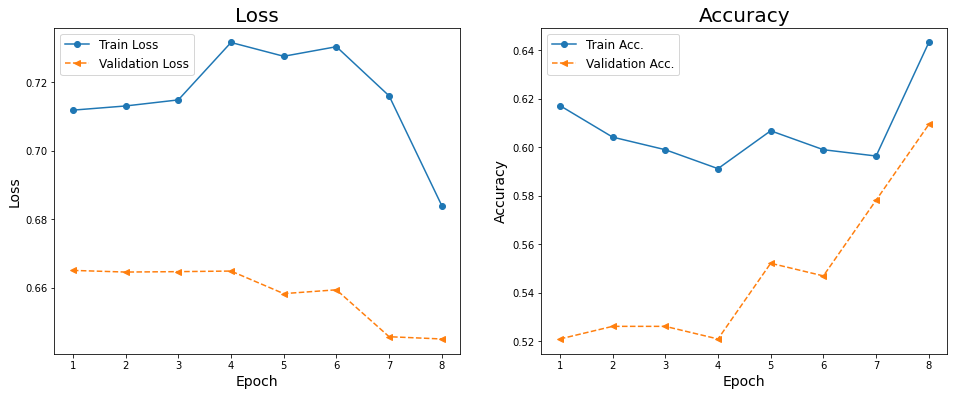

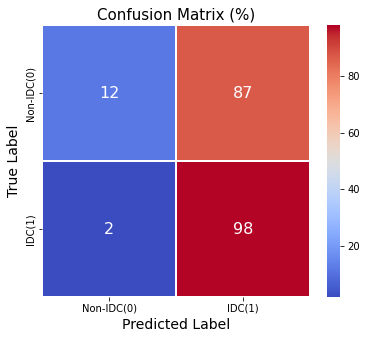

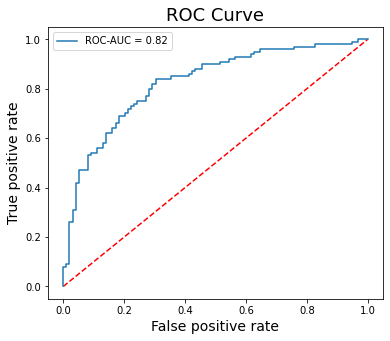

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 128)       18560     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 46, 46, 128)      0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 128)      512       
 ormalization)                                                   
                                                        

,Augmented,Test_acc,Training_acc,Val_acc,Num_params,Accuracy,Precision,Recall,F1_score,Error Rate,ROC-AUC score,Cohen Kappa,Zero-One Loss
0,YES,0.55,0.64,0.61,"54,731,944",0.55,0.53,0.98,0.69,0.45,0.82,0.1,0.45


In [27]:
history = model.fit(train_data_generator,
                  epochs=EPOCHS,
                  shuffle=False,
                  batch_size=BATCH_SIZE,                  
                  steps_per_epoch=train_generator.shape[0]//BATCH_SIZE, 
                  callbacks=[lr_reduce, checkpoint, stop_early],
                  validation_data = validation_data_generator,
                  validation_steps=val_generator.shape[0]//BATCH_SIZE)

hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(1,2,1)
ax.plot(x_arr, hist['loss'], '-o', label='Train Loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation Loss')
ax.legend(fontsize=12)
ax.set_xlabel('Epoch', size=14)
ax.set_ylabel('Loss', size=14)
ax.set_title('Loss', size=20)

ax = fig.add_subplot(1,2,2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train Acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation Acc.')
ax.legend(fontsize=12)
ax.set_xlabel('Epoch', size=14)
ax.set_ylabel('Accuracy', size=14)
ax.set_title('Accuracy', size=20);

# Test accuracy - model.evaluate() 
test_accuracy = round(model.evaluate(test_data_generator, verbose=0, return_dict=True)['accuracy'], 2)
training_accuracy = round(history.history['accuracy'][-1], 2)
val_accuracy = round(history.history['val_accuracy'][-1], 2)
count_params = model.count_params()

# def error_analysis(model_name, model, test_labels, test_data_generator):
num_of_test_samples = len(test_labels)
classes = ['Non-IDC(0)','IDC(1)']

y_true = test_data_generator.classes
print('y_true:\n', y_true[:5])
# y_pred = model.predict_generator(test_data_generator, num_of_test_samples // BATCH_SIZE + 1)    # probabilities
# y_pred_argmax = (model.predict(test_data_generator) > 0.5).astype('int32')
y_pred = model.predict(test_data_generator)
print('y_pred:\n', y_pred[:5])
# y_pred_argmax = (y_pred > 0.5).astype('int32')
y_pred_argmax = np.argmax(y_pred, axis=1)                      # 0s and 1s: return the indicies of the max values along the axis (axis=1: each row)   TODO: look into prob threshold
print('y_pred_argmax:\n', y_pred_argmax[:10])

# Confusion matrix  
conf_max = confusion_matrix(y_true, y_pred_argmax)             # conf.max should use 0s and 1s for y_pred
perf_conf_max = conf_max.astype('float')/conf_max.sum(axis=1)[:np.newaxis]*100
df_perf_conf_max = pd.DataFrame(perf_conf_max, index=classes, columns=classes)

plt.figure(figsize=(6,5))
sns.heatmap(df_perf_conf_max, annot=True, cmap='coolwarm', annot_kws={'fontsize':16}, linewidth=0.5, fmt='.0f')  
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Confusion Matrix (%)', fontsize=15)

# Classification report (classification_report should use 0s and 1s for y_pred)
print('=============== Classification Report ===============\n\n', classification_report(y_true, y_pred_argmax, target_names=['Non-IDC', 'IDC']), '\n=====================================================\n')

# Cross validation score
# cv = ShuffleSplit(n_splits=100, test_size=.25, random_state=0)
# cv_score = np.median(cross_val_score(model, y_true, y_pred, cv=cv))*100
# print('cv_score = ',cv_score)

# Precision, recall, and f1_score
tn, fp, fn, tp = confusion_matrix(y_true, y_pred_argmax).ravel()     # np.ravel(): returns contiguous flattened array (1D array with all the input-array elements and with the same type as it)
# accuracy = round(accuracy_score(y_true, y_pred_argmax), 2)
# accuracy = round(accuracy_score(y_true, y_pred_argmax), 2)
# recall = round(recall_score(y_true, y_pred_argmax), 2)
# precision = round(precision_score(y_true, y_pred_argmax), 2)

accuracy = round((tp+tn)/(tp+fn+tn+fp), 2)
recall = round(tp/(fn+tp), 2)
precision = round(tp/(fp+tp), 2)

f1score = round((2*precision*recall)/(precision+recall), 2)
error_rate = round(1-accuracy, 2)

# cohen_kappa score and zero_one loss
cohen_kappa = round(cohen_kappa_score(y_true, y_pred_argmax), 2)
zo_loss = round(zero_one_loss(y_true, y_pred_argmax), 2)

# Area under the ROC curve
roc_log = roc_auc_score(y_true, y_pred[:,1], multi_class='ovr')   # for the roc curve, we need to use a vector of probabilities so just chose one column and all rows
fpr, tpr, threshold = roc_curve(y_true, y_pred[:,1])
area_under_curve = round(auc(fpr, tpr), 2)  

plt.figure(figsize=(6,5))
plt.plot([0, 1], [0, 1], 'r--')  
plt.plot(fpr, tpr, label='ROC-AUC = {:.2f}'.format(area_under_curve))  
plt.xlabel('False positive rate', fontsize=14)
plt.ylabel('True positive rate', fontsize=14)
plt.title('ROC Curve', fontsize=18)
plt.legend(loc='best')
plt.show()
plt.close()

model_summary = pd.DataFrame({'Augmented':'YES',
                              'Test_acc':test_accuracy,
                              'Training_acc': training_accuracy,
                              'Val_acc': val_accuracy,
                              'Num_params':  f'{count_params:,}',
                              'Accuracy': accuracy,
                              'Precision': precision,
                              'Recall': recall,
                              'F1_score': f1score,
                              'Error Rate': error_rate,
                              'ROC-AUC score': area_under_curve,
                              'Cohen Kappa': cohen_kappa,
                              'Zero-One Loss': zo_loss}, index=[0]) 
print(model.summary())
model_summary

In [28]:
print('best_hps.values:\n', best_hps.values, '\n')
print(tuner.results_summary(1))   # hyperparameter values of top 10 models
print(model.summary())

best_hps.values:
 {'kernel_size': 3, 'strides': 1, 'pool_size': 3, 'activation': 'gelu', 'optimizer': 'adam', 'filters_1': 64, 'dense_units': 202, 'learning_rate': 0.005628390033532212, 'dropout_rate': 0.1, 'reduction_type': 'max_pooling2d', 'input_units': 16, 'n_layers': 1, 'conv2d_0_units': 128, 'dropout': False, 'conv2d_1_units': 64} 

Results summary
Results in hj_dir/breast_cancer_classification
Showing 1 best trials
Trial summary
Hyperparameters:
kernel_size: 3
strides: 1
pool_size: 3
activation: gelu
optimizer: adam
filters_1: 64
dense_units: 202
learning_rate: 0.005628390033532212
dropout_rate: 0.1
reduction_type: max_pooling2d
input_units: 16
n_layers: 1
conv2d_0_units: 128
dropout: False
conv2d_1_units: 64
Score: 0.7309644818305969
None
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 16)        160       
                         

In [29]:
# Display the hyperparameter values of top 10 models 
# tuner.results_summary()                                 # tuner.results_summary(1) => hyperparameter values of top model

# [Interpretation of Confusion Matrix](https://towardsdatascience.com/a-look-at-precision-recall-and-f1-score-36b5fd0dd3ec)




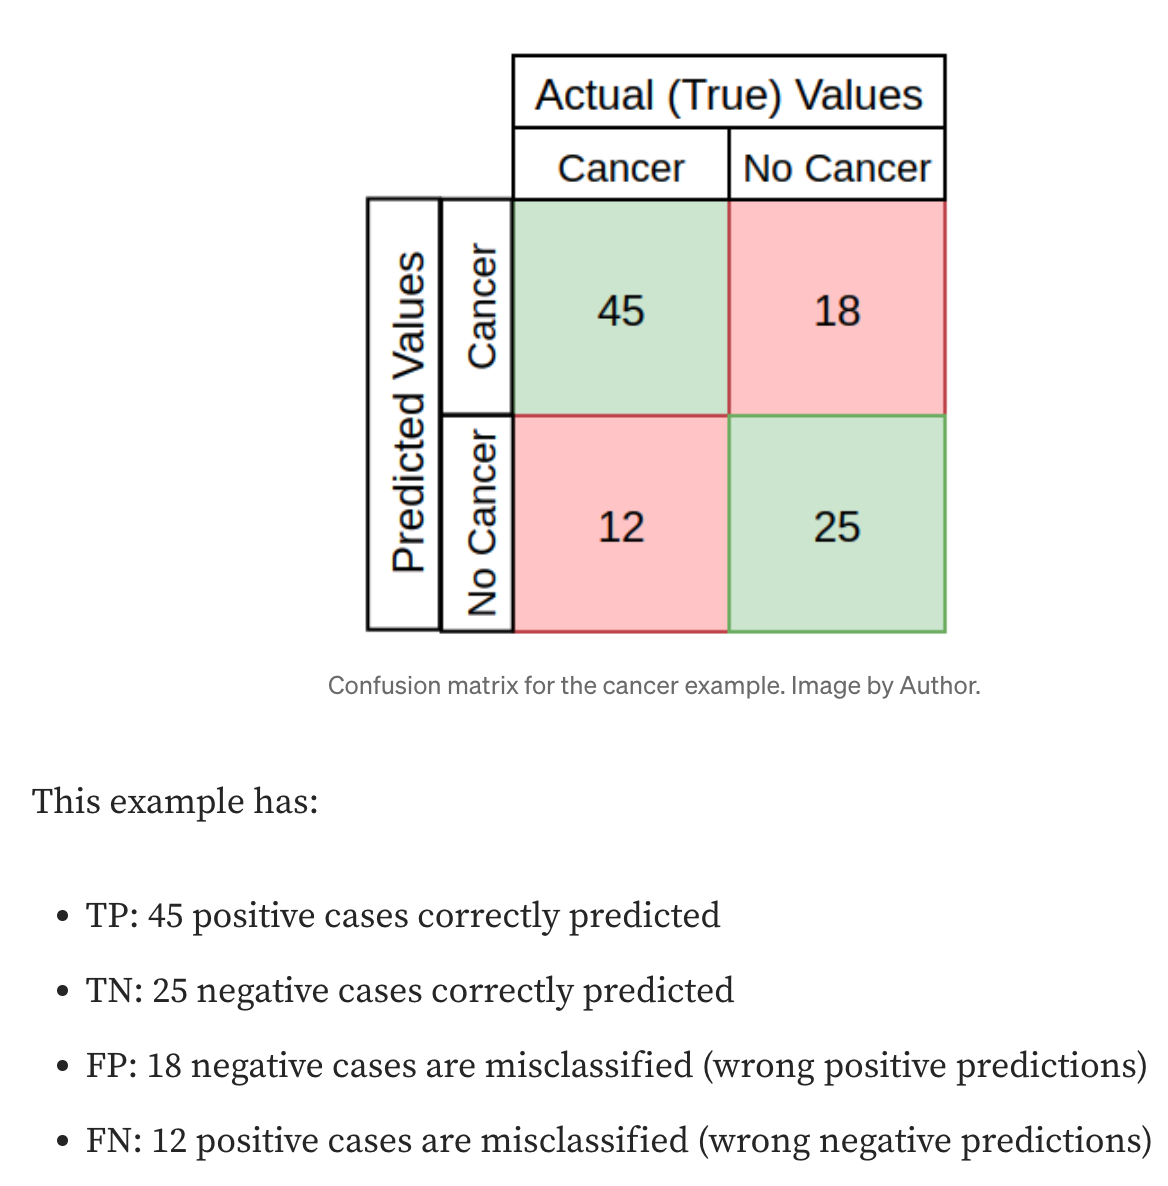

In [30]:
# from sklearn.model_selection import cross_val_score
# from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, classification_report
# from sklearn import svm
# from sklearn.metrics import auc
# from sklearn.metrics import RocCurveDisplay
# from sklearn.model_selection import StratifiedKFold
# from sklearn.metrics import roc_curve


# # def error_analysis(model_name, model, test_labels, test_data_generator):
# num_of_test_samples = len(test_labels)
# classes = ['Non-IDC(0)','IDC(1)']

# y_true = test_data_generator.classes
# print('y_true:\n', y_true[:10])
# # y_pred = model.predict_generator(test_data_generator, num_of_test_samples // BATCH_SIZE + 1)    # probabilities
# # y_pred_argmax = (model.predict(test_data_generator) > 0.5).astype('int32')
# y_pred = model.predict(test_data_generator)
# print('y_pred:\n', y_pred[:10])
# # y_pred_argmax = (y_pred > 0.5).astype('int32')
# y_pred_argmax = np.argmax(y_pred, axis=1)                      # 0s and 1s: return the indicies of the max values along the axis (axis=1: each row)   TODO: look into prob threshold
# print('y_pred_argmax:\n', y_pred_argmax[:10])

# # Confusion matrix  
# conf_max = confusion_matrix(y_true, y_pred_argmax)             # conf.max should use 0s and 1s for y_pred
# perf_conf_max = conf_max.astype('float')/conf_max.sum(axis=1)[:np.newaxis]*100
# df_perf_conf_max = pd.DataFrame(perf_conf_max, index=classes, columns=classes)

# plt.figure(figsize=(6,5))
# sns.heatmap(df_perf_conf_max, annot=True, cmap='coolwarm', annot_kws={'fontsize':16}, linewidth=0.5, fmt='.0f')  
# plt.xlabel('Predicted Label', fontsize=14)
# plt.ylabel('True Label', fontsize=14)
# plt.title('Confusion Matrix (%)', fontsize=15)

# # Classification report (classification_report should use 0s and 1s for y_pred)
# print('=============== Classification Report ===============\n\n', classification_report(y_true, y_pred_argmax, target_names=['Non-IDC', 'IDC']), '\n=====================================================\n')

# # Cross validation score
# # cv = ShuffleSplit(n_splits=100, test_size=.25, random_state=0)
# # cv_score = np.median(cross_val_score(model, y_true, y_pred, cv=cv))*100
# # print('cv_score = ',cv_score)

# # Precision, recall, and f1_score
# tn, fp, fn, tp = confusion_matrix(y_true, y_pred_argmax).ravel()     # np.ravel(): returns contiguous flattened array (1D array with all the input-array elements and with the same type as it)
# # accuracy = round(accuracy_score(y_true, y_pred_argmax), 2)
# # accuracy = round(accuracy_score(y_true, y_pred_argmax), 2)
# # recall = round(recall_score(y_true, y_pred_argmax), 2)
# # precision = round(precision_score(y_true, y_pred_argmax), 2)

# accuracy = round((tp+tn)/(tp+fn+tn+fp), 2)
# recall = round(tp/(fn+tp), 2)
# precision = round(tp/(fp+tp), 2)

# f1score = round((2*precision*recall)/(precision+recall), 2)
# error_rate = round(1-accuracy, 2)

# # cohen_kappa score and zero_one loss
# cohen_kappa = round(cohen_kappa_score(y_true, y_pred_argmax), 2)
# zo_loss = round(zero_one_loss(y_true, y_pred_argmax), 2)

# # Area under the ROC curve
# roc_log = roc_auc_score(y_true, y_pred[:,1], multi_class='ovr')   # for the roc curve, we need to use a vector of probabilities so just chose one column and all rows
# fpr, tpr, threshold = roc_curve(y_true, y_pred[:,1])
# area_under_curve = round(auc(fpr, tpr), 2)  

# plt.figure(figsize=(6,5))
# plt.plot([0, 1], [0, 1], 'r--')  
# plt.plot(fpr, tpr, label='ROC-AUC = {:.2f}'.format(area_under_curve))  
# plt.xlabel('False positive rate', fontsize=14)
# plt.ylabel('True positive rate', fontsize=14)
# plt.title('ROC Curve', fontsize=18)
# plt.legend(loc='best')
# plt.show()
# plt.close()

# model_summary = pd.DataFrame({
#                               'Accuracy': accuracy,
#                               'Precision': precision,
#                               'Recall': recall,
#                               'F1_score': f1score,
#                               'Error Rate': error_rate,
#                               'ROC-AUC score': area_under_curve,
#                               'Cohen Kappa': cohen_kappa,
#                               'Zero-One Loss': zo_loss}, index=[0]) 
# model_summary
  
# # error_analysis('CNN', model, test_labels, test_data_generator)

In [31]:
# from sklearn.model_selection import cross_val_score
# from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, classification_report
# from sklearn import svm
# from sklearn.metrics import auc
# from sklearn.metrics import RocCurveDisplay
# from sklearn.model_selection import StratifiedKFold
# from sklearn.metrics import roc_curve


# def error_analysis(model_name, model, test_labels, test_data_generator):
#   num_of_test_samples = len(test_labels)
#   classes = ['Non-IDC(0)','IDC(1)']

#   y_true = test_data_generator.classes
#   # y_pred = model.predict_generator(test_data_generator, num_of_test_samples // BATCH_SIZE + 1)    # probabilities
#   # y_pred = model.predict(test_data_generator > 0.5)
#   y_pred = (model.predict(test_data_generator) > 0.5).astype('int32')
#   y_pred_argmax = np.argmax(y_pred, axis=1)                      # 0s and 1s: return the indicies of the max values along the axis (axis=1: each row)   TODO: look into prob threshold


#   # Confusion matrix  
#   conf_max = confusion_matrix(y_true, y_pred_argmax)             # conf.max should use 0s and 1s for y_pred
#   perf_conf_max = conf_max.astype('float')/conf_max.sum(axis=1)[:np.newaxis]*100
#   df_perf_conf_max = pd.DataFrame(perf_conf_max, index=classes, columns=classes)

#   plt.figure(figsize=(6,5))
#   sns.heatmap(df_perf_conf_max, annot=True, cmap='coolwarm', annot_kws={'fontsize':16}, linewidth=0.5, fmt='.0f')  
#   plt.xlabel('Predicted Label', fontsize=14)
#   plt.ylabel('True Label', fontsize=14)
#   plt.title('Confusion Matrix (%)', fontsize=15)
  
#   # Classification report (classification_report should use 0s and 1s for y_pred)
#   print('=============== Classification Report ===============\n\n', classification_report(y_true, y_pred_argmax, target_names=['Non-IDC', 'IDC']), '\n=====================================================\n')
  
#   # Cross validation score
#   # cv = ShuffleSplit(n_splits=100, test_size=.25, random_state=0)
#   # cv_score = np.median(cross_val_score(model, y_true, y_pred, cv=cv))*100
#   # print('cv_score = ',cv_score)

#   # Precision, recall, and f1_score
#   tn, fp, fn, tp = confusion_matrix(y_true, y_pred_argmax).ravel()     # np.ravel(): returns contiguous flattened array (1D array with all the input-array elements and with the same type as it)
#   accuracy = round(accuracy_score(y_true, y_pred_argmax), 2)
#   precision = round(precision_score(y_true, y_pred_argmax), 2)
#   recall = round(recall_score(y_true, y_pred_argmax), 2)
#   f1score = round((2*precision*recall)/(precision+recall), 2)
#   error_rate = round(1-accuracy, 2)

#   # cohen_kappa score and zero_one loss
#   cohen_kappa = round(cohen_kappa_score(y_true, y_pred_argmax), 2)
#   zo_loss = round(zero_one_loss(y_true, y_pred_argmax), 2)

#   # Area under the ROC curve
#   roc_log = roc_auc_score(y_true, y_pred[:,1], multi_class='ovr')   # for the roc curve, we need to use a vector of probabilities so just chose one column and all rows
#   fpr, tpr, threshold = roc_curve(y_true, y_pred[:,1])
#   area_under_curve = round(auc(fpr, tpr), 2)  

#   plt.figure(figsize=(6,5))
#   plt.plot([0, 1], [0, 1], 'r--')  
#   plt.plot(fpr, tpr, label='ROC-AUC = {:.2f}'.format(area_under_curve))  
#   plt.xlabel('False positive rate', fontsize=14)
#   plt.ylabel('True positive rate', fontsize=14)
#   plt.title('ROC Curve', fontsize=18)
#   plt.legend(loc='best')
#   plt.show()
#   plt.close()

#   model_summary = pd.DataFrame({'Model':model_name,
#                                 'Accuracy': accuracy,
#                                 'Precision': precision,
#                                 'Recall': recall,
#                                 'F1_score': f1score,
#                                 'Error Rate': error_rate,
#                                 'ROC-AUC score': area_under_curve,
#                                 'Cohen Kappa': cohen_kappa,
#                                 'Zero-One Loss': zo_loss}, index=[0]) 
#   return model_summary
  
# error_analysis('CNN', model, test_labels, test_data_generator)

In [32]:
# # plot my model architecture
# tf.keras.utils.plot_model(
#     model,
#     show_shapes=True,
#     show_layer_names=False,
#     show_layer_activations=True,
# )

In [33]:
# !pip install cufflinks


In [34]:
# from plotly.subplots import make_subplots
# labels=['IDC Malignant', 'IDC Benign']
# values = [78786, 198738]
# colors = ['#f5b3ae','#c3f3fa']

# fig = make_subplots(1,1, specs=[[{'type':'domain'}]],
#                    subplot_titles=[''])
# fig.add_trace(go.Pie(labels=labels, values=values, textinfo='label+percent', pull=[0.1, 0], scalegroup='one', marker_colors=colors,
#                     name='data_split'), 1,1)


# fig.update_layout(title_text='Data Split Before Sampling')
# fig.show()